# Proyecto Final: Clasificación, Simulación y modelo para API
Este notebook trabaja con `analytics.daily_features` para predecir `target_up` (1 si `close > open`) y testar una estrategia en 2025. Se usan solo features de mercado.

#1. Definición del problema

○ Explicar target_up y la decisión que habilita.

En este caso tenemos datos de activos financieros obtenidos directamente desde la API de Yahoo Finance. Con dichos datos de mercado cargos y promovidos a esquema analytics.
se plantea el hacerlos utiles para el desarrollo de un modelo de Machine Learning que permita predecir directamente la variable objetivo 'target_up' la cual es una variable de tipo
binario que consiste en indicar con valor de 1 si al final del día un activo financiero cerro a la alza (valor de cierre mayor a valor de apertura) o con un 0 en caso de que dicho
activo haya cerrado a la baja (valor de cierre menor a valor de apertura). Dicha variable es trascendental para calcular la posibilidad de pérdidas en un día en específico para una 
inversión con base en los datos históricos lo cual es súper importante ya que nos habilita la decisión de saber si está bien invertir o no en determinado activo con base en datos
que conocemos a inicio de un día pudiendo predecir si va a ser beneficioso para nosotros dicha inversión (target_up igual a 1) o no (target_up igual a 0)

In [33]:
!pip install python-dotenv
!pip install lightgbm
!pip install xgboost

In [83]:
#2. Carga de datos
# Leer desde Postgres o CSV exportado.

import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import numpy as np

load_dotenv()

jar_path = "/home/jovyan/work/postgresql-42.2.5.jar"
spark = (SparkSession.builder
    .appName("ML Trading Classifier")
    .master("local[*]")
    .config("spark.jars", jar_path)
    .config("spark.driver.extraClassPath", jar_path)
    .config("spark.executor.extraClassPath", jar_path)
    .getOrCreate())

analytics_table = "analytics." + os.getenv("ANALYTICS_TABLE", "daily_features")
df_spark = (spark.read.format("jdbc")
    .option("url", f"jdbc:postgresql://warehouses:5432/{os.getenv('POSTGRES_DB')}")
    .option("driver", "org.postgresql.Driver")
    .option("dbtable", analytics_table)
    .option("user", os.getenv('POSTGRES_USER'))
    .option("password", os.getenv('POSTGRES_PASSWORD'))
    .load())


df_spark = df_spark.where(
    (F.col("open") > 0) &
    (F.col("volume") >= 0) &
    (F.col("high") >= F.greatest(F.col("open"), F.col("close"), F.col("low"))) &
    (F.col("low") <= F.least(F.col("open"), F.col("close"), F.col("high")))
)

df_pd = df_spark.toPandas()
print(df_pd.shape)

(14840, 21)


Shape df_pd: (14840, 21)
Tickers: ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'INTC', 'JPM', 'MSFT', 'NVDA', 'SPY', 'TSLA']
Rango de fechas: 2020-01-06 00:00:00  hasta  2025-11-28 00:00:00
Balance de clases (global):
            count  proportion
target_up                    
up         7677.0         NaN
down       7163.0         NaN
up_%          NaN       51.73
down_%        NaN       48.27

Balance por ticker:
           n  up_rate_%
ticker                 
SPY     1484      54.72
AAPL    1484      53.98
GOOGL   1484      53.91
MSFT    1484      52.83
NVDA    1484      52.29
JPM     1484      51.42
AMZN    1484      50.07
TSLA    1484      49.87
AMD     1484      49.26
INTC    1484      48.99


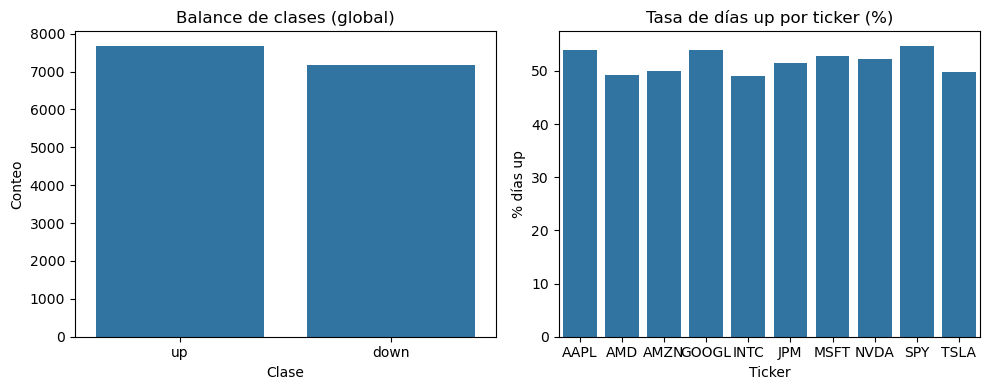

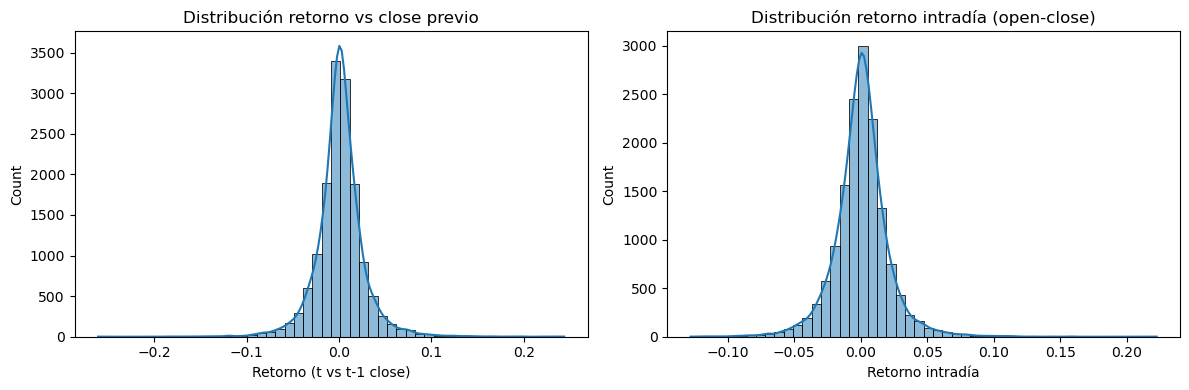

In [84]:
#3. EDA breve
# Balance de clases (días up/down).
# Distribución de retornos.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Asegurar que target_up existe 
if 'target_up' not in df_pd.columns:
    df_pd['target_up'] = (df_pd['close'] > df_pd['open']).astype(int)

print('Shape df_pd:', df_pd.shape)
print('Tickers:', sorted(df_pd['ticker'].unique()))
print('Rango de fechas:', df_pd['date'].min(), ' hasta ', df_pd['date'].max())

# Balance de clases global y por ticker
class_balance = df_pd['target_up'].value_counts().rename({0:'down',1:'up'})
class_pct = (df_pd['target_up'].value_counts(normalize=True)*100).round(2).rename({0:'down_%',1:'up_%'})
print('Balance de clases (global):')
print(pd.concat([class_balance, class_pct], axis=1))

print('\nBalance por ticker:')
by_tk = df_pd.groupby('ticker')['target_up'].agg(['count','mean'])
by_tk.rename(columns={'count':'n','mean':'up_rate'}, inplace=True)
by_tk['up_rate_%'] = (by_tk['up_rate']*100).round(2)
print(by_tk[['n','up_rate_%']].sort_values('up_rate_%', ascending=False))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='target_up', data=df_pd.replace({'target_up':{0:'down',1:'up'}}), ax=axes[0])
axes[0].set_title('Balance de clases (global)')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Conteo')

sns.barplot(x=by_tk.index, y=by_tk['up_rate_%'], ax=axes[1])
axes[1].set_title('Tasa de días up por ticker (%)')
axes[1].set_xlabel('Ticker')
axes[1].set_ylabel('% días up')
plt.tight_layout()
plt.show()

# Distribución de retornos
ret_cols = [c for c in ['return_prev_close'] if c in df_pd.columns]
if len(ret_cols) == 0:
    df_pd['ret_prev_close'] = np.nan
else:
    df_pd['ret_prev_close'] = df_pd[ret_cols[0]]

df_pd['ret_intraday'] = (df_pd['close']/df_pd['open'] - 1.0)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_pd['ret_prev_close'].dropna(), bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribución retorno vs close previo')
axes[0].set_xlabel('Retorno (t vs t-1 close)')

sns.histplot(df_pd['ret_intraday'].dropna(), bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribución retorno intradía (open-close)')
axes[1].set_xlabel('Retorno intradía')
plt.tight_layout()
plt.show()

In [112]:
#4.  Features y target
#Seleccionar columnas.
#Justificar lags y ventanas

features = [
    "year", "month", "day_of_week",
    "open", "return_prev_close", "volatility_n_days", "volume",
    "is_monday", "is_friday"
] #Solo uso features disponibles al inicio del dia nada mas para asi evitar leakage sin nada de close

#En este caso el valor de close no debe ser utilizado porque es lo que no sabemos, tampoco sabemos high y low porque esos son los valores mas altos y bajos y eso solo se sabra igual al cierre del dia, el volume ofertado igual no lo se

In [113]:
df_pd = df_pd.dropna()
train_df = df_pd[df_pd['year'] <= 2023].copy()
val_df = df_pd[df_pd['year'] == 2024].copy()
test_df = df_pd[df_pd['year'] == 2025].copy()

In [114]:
import pandas as pd
import numpy as np

train_counts = train_df['target_up'].value_counts()
print('Train original counts:', train_counts.to_dict())

minority_class = train_counts.idxmin()
majority_class = train_counts.idxmax()
n_min = int(train_counts.min())
n_maj = int(train_counts.max())
print('Clase Minoritaria:', minority_class, 'conteo:', n_min)
print('Clase Mayoritaria:', majority_class, 'conteo:', n_maj)

train_min = train_df[train_df['target_up'] == minority_class]
train_maj = train_df[train_df['target_up'] == majority_class]
train_maj_bal = train_maj.sample(n=n_min, random_state=42)
balanced_train_df = pd.concat([train_min, train_maj_bal], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
print('Train balanced (undersampling) counts:', balanced_train_df['target_up'].value_counts().to_dict())

Train original counts: {1: 5187, 0: 4853}
Clase Minoritaria: 0 conteo: 4853
Clase Mayoritaria: 1 conteo: 5187
Train balanced (undersampling) counts: {0: 4853, 1: 4853}


In [115]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

X_train = balanced_train_df[features]
y_train = balanced_train_df['target_up'].astype(int)
X_val = val_df[features]
y_val = (val_df['target_up']).astype(int)
X_test = test_df[features]
y_test = (test_df['target_up']).astype(int)

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, features)
])

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    'logreg': (LogisticRegression(max_iter=1000), { 'C':[0.1,1,10] }),
    'dtree': (DecisionTreeClassifier(), { 'max_depth':[3,5,7] }),
    'rf': (RandomForestClassifier(n_estimators=200), { 'max_depth':[5,10,None] }),
    'gboost': (GradientBoostingClassifier(), { 'n_estimators':[100,200], 'learning_rate':[0.05,0.1] }),
    'adaboost': (AdaBoostClassifier(), { 'n_estimators':[100,200] }),
    'xgb': (XGBClassifier(eval_metric='logloss'), { 'n_estimators':[100,200], 'max_depth':[3,5] }),
    'lgbm': (LGBMClassifier(), { 'n_estimators':[100,200], 'num_leaves':[31,50] })
}


tscv = TimeSeriesSplit(n_splits=4)
results = []
best_model = None
best_name = None
best_f1 = -1
best_params = None

for name, (clf, params) in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', clf)])
    grid = GridSearchCV(pipe, {'clf__' + k: v for k,v in params.items()}, cv=tscv, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_val)
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, grid.predict_proba(X_val)[:,1]) if hasattr(grid.best_estimator_['clf'], 'predict_proba') else None
    }
    results.append(metrics)
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_model = grid.best_estimator_
        best_name = name
        best_params = grid.best_params_

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values('f1', ascending=False))
print(f"Mejor modelo {best_name}")
print(best_params)

      model  accuracy  precision    recall        f1   roc_auc
5       xgb  0.819444   0.808418  0.853640  0.830414  0.889402
1     dtree  0.820238   0.818386  0.839080  0.828604  0.880035
3    gboost  0.813095   0.795745  0.859770  0.826519  0.892296
2        rf  0.817460   0.817908  0.832950  0.825361  0.885838
6      lgbm  0.813889   0.808715  0.839080  0.823618  0.890323
4  adaboost  0.806746   0.814132  0.812261  0.813195  0.875476
0    logreg  0.790079   0.755599  0.878927  0.812611  0.881798
Mejor modelo xgb
{'clf__max_depth': 3, 'clf__n_estimators': 100}


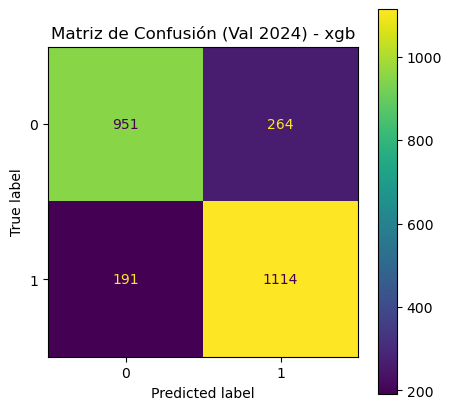

In [116]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)
plt.title(f"Matriz de Confusión (Val 2024) - {best_name}")
plt.show()

In [117]:
from sklearn.base import clone

results_sorted = results_df.sort_values('f1', ascending=False).reset_index(drop=True)
print(results_sorted)
best_name = results_sorted.loc[0, 'model']
print(f"Modelo ganador: {best_name}")

clf, params = models[best_name]
winner_pipe = Pipeline([('preprocessor', preprocessor), ('clf', clf)])

X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)
winner_pipe.fit(X_trainval, y_trainval)
print("Reentrenamiento completado en Train+Val")

      model  accuracy  precision    recall        f1   roc_auc
0       xgb  0.819444   0.808418  0.853640  0.830414  0.889402
1     dtree  0.820238   0.818386  0.839080  0.828604  0.880035
2    gboost  0.813095   0.795745  0.859770  0.826519  0.892296
3        rf  0.817460   0.817908  0.832950  0.825361  0.885838
4      lgbm  0.813889   0.808715  0.839080  0.823618  0.890323
5  adaboost  0.806746   0.814132  0.812261  0.813195  0.875476
6    logreg  0.790079   0.755599  0.878927  0.812611  0.881798
Modelo ganador: xgb
Reentrenamiento completado en Train+Val


              precision    recall  f1-score   support

           0     0.7591    0.8000    0.7790      1095
           1     0.8055    0.7654    0.7849      1185

    accuracy                         0.7820      2280
   macro avg     0.7823    0.7827    0.7820      2280
weighted avg     0.7832    0.7820    0.7821      2280



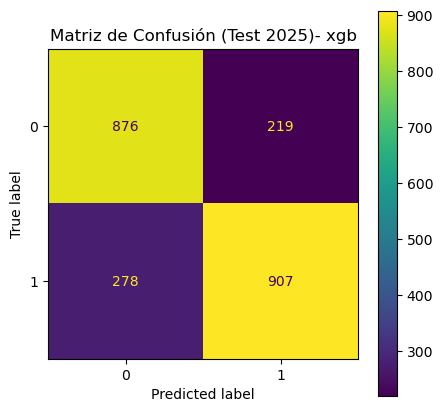

In [118]:
test_exp_df = df_pd[df_pd['year'].isin([2025])].copy()
X_test_exp = test_exp_df[features]
y_test_exp = test_exp_df['target_up'].astype(int)

y_pred_test_exp = winner_pipe.predict(X_test_exp)
from sklearn.metrics import classification_report
print(classification_report(y_test_exp, y_pred_test_exp, digits=4))

cm_exp = confusion_matrix(y_test_exp, y_pred_test_exp)
disp_exp = ConfusionMatrixDisplay(confusion_matrix=cm_exp)
fig, ax = plt.subplots(figsize=(5,5))
disp_exp.plot(ax=ax)
plt.title(f"Matriz de Confusión (Test 2025)- {best_name}")
plt.show()

In [119]:
test_exp_df = test_exp_df.assign(pred=y_pred_test_exp)
errors_df = test_exp_df[(test_exp_df['target_up'] != test_exp_df['pred'])].copy()
print(f"Errores totales en Test: {len(errors_df)}")

if 'volatility_n_days' in errors_df.columns:
    print("Errores por cuartil de volatilidad:")
    errors_df['vol_q'] = pd.qcut(errors_df['volatility_n_days'], 4, duplicates='drop')
    print(errors_df.groupby('vol_q')['target_up'].count())

print("Errores por día de la semana:")
print(errors_df.groupby('day_of_week')['target_up'].count().sort_index())

Errores totales en Test: 497
Errores por cuartil de volatilidad:
vol_q
(0.00259, 0.013]    125
(0.013, 0.0217]     124
(0.0217, 0.0307]    124
(0.0307, 0.0731]    124
Name: target_up, dtype: int64
Errores por día de la semana:
day_of_week
1    104
2    103
3    101
4     98
5     91
Name: target_up, dtype: int64


In [120]:
import os, joblib
MODEL_PATH = os.getenv('MODEL_PATH', '/home/jovyan/work/models/best_pipeline.joblib')
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
joblib.dump(winner_pipe, MODEL_PATH)
print(f"Modelo exportado a: {MODEL_PATH}")

Modelo exportado a: /home/jovyan/work/models/best_pipeline.joblib


Predicciones día a día 2025

Métricas del ML reales en Test 2025
F1 Test: 0.7849
ROC-AUC Test: 0.8491

Simulación inversión 2025
Capital final: 30722.21 USD
Total Return: 307.22 %
Número de trades ejecutados: 116
Máximo Drawdown: -4.33 %


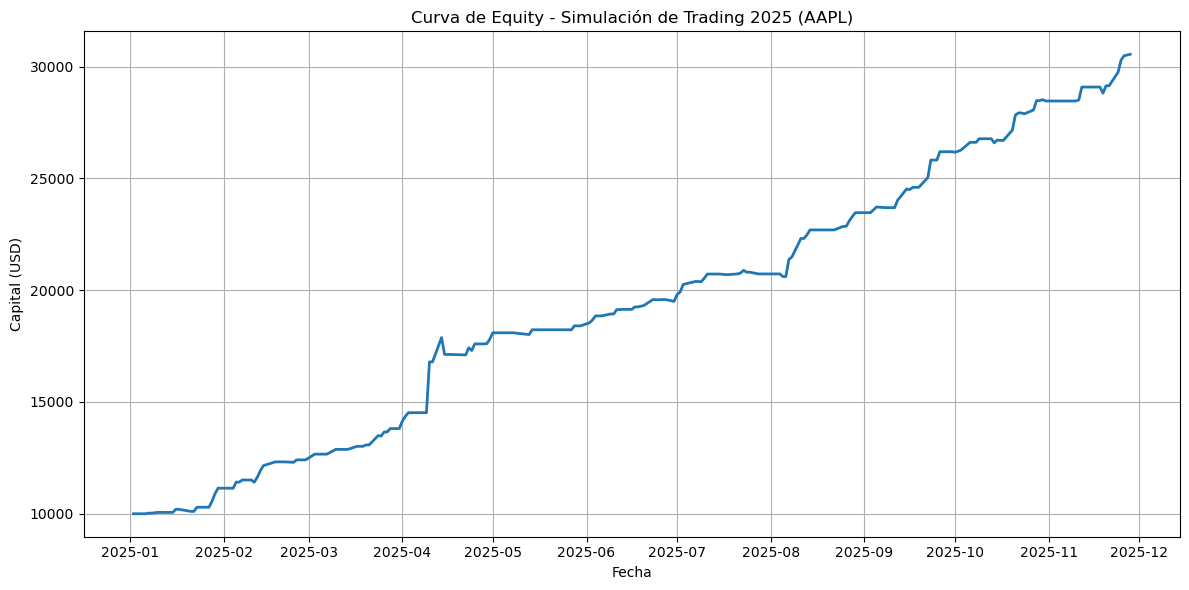

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score

df_2025 = (
    df_pd[df_pd["ticker"] == "AAPL"]
    .query('"2025-01-01" <= date <= "2025-11-30"')
    .sort_values("date")
)

df_2025_closes = df_2025[["date", "open", "close"]].reset_index(drop=True)
df_2025_pred = df_2025[features].reset_index(drop=True)

capitalInicial = 10000
capital = capitalInicial
equity_curve = []
numero_trades = 0

print("Predicciones día a día 2025")

for i, row in df_2025_pred.iterrows():

    row_df = pd.DataFrame([row])

    y_pred = winner_pipe.predict(row_df)[0]

    equity_curve.append(capital)
    
    if y_pred == 1:
        capital = (capital / df_2025_closes.loc[i, "open"]) * df_2025_closes.loc[i, "close"]
        numero_trades += 1

# Test
y_test_pred = winner_pipe.predict(X_test)
y_test_proba = winner_pipe.predict_proba(X_test)[:,1]

f1_test = f1_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_proba)

retorno_total = (capital / capitalInicial) * 100

# Drawdown máximo
equity_array = np.array(equity_curve)
max_equity = np.maximum.accumulate(equity_array)
drawdowns = (equity_array - max_equity) / max_equity
max_drawdown = drawdowns.min() * 100

print("\nMétricas del ML reales en Test 2025")
print(f"F1 Test: {f1_test:.4f}")
print(f"ROC-AUC Test: {auc_test:.4f}")

print("\nSimulación inversión 2025")
print(f"Capital final: {capital:.2f} USD")
print(f"Total Return: {retorno_total:.2f} %")
print(f"Número de trades ejecutados: {numero_trades}")
print(f"Máximo Drawdown: {max_drawdown:.2f} %")

plt.figure(figsize=(12, 6))
plt.plot(df_2025_closes["date"], equity_curve, linewidth=2)
plt.xlabel("Fecha")
plt.ylabel("Capital (USD)")
plt.title("Curva de Equity - Simulación de Trading 2025 (AAPL)")
plt.grid(True)
plt.tight_layout()
plt.show()

Relación entre las métricas de Machine Learning y el rendimiento financiero

Las métricas de validación (por ejemplo, F1 y ROC-AUC) reflejan qué tan bien el modelo distingue entre días Up y Down dentro del conjunto de entrenamiento/validación. Un F1 alto sugiere que el modelo identifica con buena precisión los días positivos (Up), especialmente cuando la clase está balanceada o cuando interesa la precisión/recall del movimiento de subida. Un ROC-AUC mayor a 0.5 indica que el modelo tiene capacidad real para separar patrones alcistas de bajistas, superando al azar.

Sin embargo, estas métricas no capturan la magnitud del movimiento, por lo que no necesariamente predicen la rentabilidad.

Si durante 2025 la estrategia genera un retorno positivo, es una señal de que las predicciones “UP” coincidieron con días donde el close fue mayor que el open con suficiente frecuencia como para generar crecimiento del capital.